In [4]:
################################
# Scientific imports
################################
import matplotlib.pyplot as plt
import numpy as np

from astroquery.mast import Observations
from astroquery.mast import Catalogs

from astropy.table import Table
from astropy.table import QTable
from astropy.io import fits
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import aggregate_downsample

import scipy
from scipy.signal import butter,filtfilt

import sktime as skt

from sktime.datatypes._panel._convert import (
    from_2d_array_to_nested,
    from_nested_to_2d_array,
    is_nested_dataframe,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, gc
from datetime import datetime
import pandas as pd
import seaborn as sb
from collections import Counter
import joblib
from joblib import Parallel, delayed, dump, load

################################
# Suppress Warnings
################################
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

################################
# Initialisers
################################
default_rc_params = (16,5)
plt.rcParams["figure.figsize"] = default_rc_params
sb.set()

# Load the Data files
fitsarr = np.load("fitslist.npy")
xNaNs = np.load("X_NAN_LIST.npy")
xTime = np.load("X_TIME_LIST.npy")

In [5]:
def DrawLC(rndFile=-1,verbose=True):
    
    # rndFile is random, unless specified
    rndFile = random.randint(0,len(fitsarr)) if rndFile==-1 else rndFile
    
    # Get LC data from the requisite fits file
    fitsFile = fitsarr[rndFile]

    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        star_teff = hdulist[0].header['TEFF']
        star_logg = hdulist[0].header['LOGG']
        star_tmag = hdulist[0].header['TESSMAG']
        obj       = hdulist[0].header['OBJECT']
        sector    = hdulist[0].header['SECTOR']


        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds     = hdulist[1].data['TIME']
        sap_fluxes    = hdulist[1].data['SAP_FLUX']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # X- and Y- labels
    ylab = "PDCSAP Flux (e-/s)"
    xlab = "Time (TBJD)"
    
    if verbose:
    #ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector), ylab, xlab)
    else:
        return (tess_bjds[1:-1], pdcsap_fluxes[1:-1])



Text(0, 0.5, 'PDCSAP Flux (e-/s)')

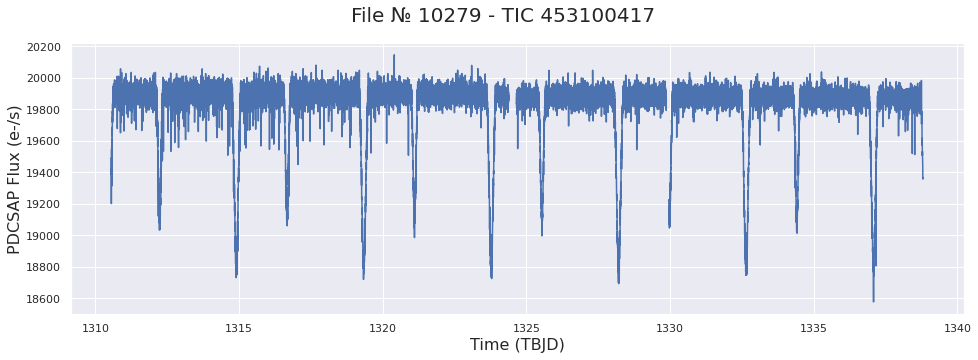

In [6]:
x,y,f,o,s,ylab,xlab = DrawLC(10279)

fig, ax = plt.subplots()

ax.plot(x,y)

fig.suptitle("File № {} - {}".format(f, o), fontsize=20) # + str(obj) + " - Sector " + str(sector))

ax.set_xlabel(xlab, fontsize=16)
ax.set_ylabel(ylab, fontsize=16)

## THE FUNCTIONS ARE BELOW

In [7]:
def FilterMyData_OLD(x, y):
    
    # Re-make the X and Y arrays
    dt      = np.diff(x)[0]
    betterX = np.arange(min(x), max(x), dt)                  # For some reason, x has NaNs in it, this makes a new, linear x scale
    betterY = y.copy()                                             # I dont think I need this here? As it's in a fn and so therefore local
    betterY[np.isnan(x)] = np.median(y)                      # Change all the missing values to the median value of the whole array
    
    # Frequency Data Stuff
    sec           = (max(betterX)-min(betterX))*24*60*60     # Number of seconds in the overall observation period
    freq          = len(betterX)/sec                         # Frequency, in Hz, ie number of observations per second
    cutoff        = 0.1*freq                                 # HYPERPARAMETER MAYBE???????? (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    
    order         = 2                                        # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, betterY)
    
    # Finally, return the new X and Y values
    return (betterX, newY)


In [8]:
def FilterMyData(y,cutVAR=0.00005):
    
    # First, let's calculate the observational time period;
    # This is done separately so that I can change this in the future for any TESS fits file
    numdays       = GetNumDays()
    
    # Next, fix data                           
    yMedian       = np.median(y)                                                    # Get the median value of 'y' before changing it
    y             = [yMedian if n in xNaNs else item for n,item in enumerate(y)]    # Change all the missing values to the median value of the whole array
    
    # Frequency Data Stuff
    sec           = numdays*24*60*60   # Number of seconds in the overall observation period
    freq          = len(y)/sec         # Frequency, in Hz, ie number of observations per second
    # FREQ IS APPROX 1/120 OR ~0.008333333
    
    #cutoff        = cutVAR*freq        # HYPERPARAMETER NOW!!!!!!!! (has to be 0 < cutoff < 0.5 because of how normal cutoff works)
    cutoff        = cutVAR
    order         = 2                  # Approximation via polynomial of the order'th degree (2=quadratic, 3=cubic, 4=quartic, etc)
    
    # Butter Lowpass Filter
    nyq           = 0.5 * freq
    normal_cutoff = cutoff / nyq
    
    print(f"freq = {freq}")
    print(f"cutoff = {cutoff}")
    print(f"nyq = {nyq}")
    print(f"normal_cutoff={normal_cutoff}")
    
    #print(f"FREQ: {freq:8f}")# \t\t NORM CUTOFF: {normal_cutoff:8f}") 
    
    b, a          = butter(order, normal_cutoff, btype='low', analog=False)
    newY          = filtfilt(b, a, y)
    
    # Finally, return the new X and Y values
    return (newY)

In [9]:
def Every_Nth_Value(y,n):
    return (y[::n])

In [10]:
def NormaliseFlux(f):
    
    # x just in place so that I can pass it through other things and persist
    
    # Normalise the Flux (y co-ords)
    mean = np.median(f)
    std=np.std(f)
    f[:] = [(number/mean) for number in f]
    
    # Return nornalised flux
    return (f)

In [11]:
def GetNumDays():
    
    nDays = xTime[-1]-xTime[0]
    
    return (nDays)

In [12]:
def PreProcessData(y, n=10):
    # x and y are monikers for "input x" and "input y"
    
    fy = Every_Nth_Value(FilterMyData(NormaliseFlux(y)),n)
    
    # NORMALISING
    #y = NormaliseFlux(y)
    
    # FILTERING
    #y = FilterMyData(y)
    
    # SUBSAMPLING
    #fy = Every_Nth_Value(fy)
    
    # RETURN
    return (fy)

In [13]:
def FixAllData(fluxlist, n=10):
    
    print(f"Total Number of LCs to fix = {len(fluxlist)}")
    
    # New Array
    tmp = np.zeros((len(fluxlist),len(fluxlist[0][::n])))
    
    print(f"TMP array has size {tmp.shape}")
    
    for indx,data in enumerate(fluxlist):
        tmpLC = PreProcessData(data,n)
        tmp[indx] = tmpLC
    
    print("Done!")
    
    return(tmp)

## THE FUNCTIONS ARE ABOVE

In [17]:
x,y     = DrawLC(10279, verbose=False)

# Just Filtered
Fx = x
Fy  = FilterMyData(y)

# Filtered then Normalised
FNx     = Fx
FNy     = NormaliseFlux(Fy.copy())

# Normalised then Filtered
NFy     = NormaliseFlux(y.copy())
NFx = x
NFy  = FilterMyData(NFy.copy())

freq = 0.008333882525137828
cutoff = 5e-05
nyq = 0.004166941262568914
normal_cutoff=0.011999209215916585
freq = 0.008333882525137828
cutoff = 5e-05
nyq = 0.004166941262568914
normal_cutoff=0.011999209215916585


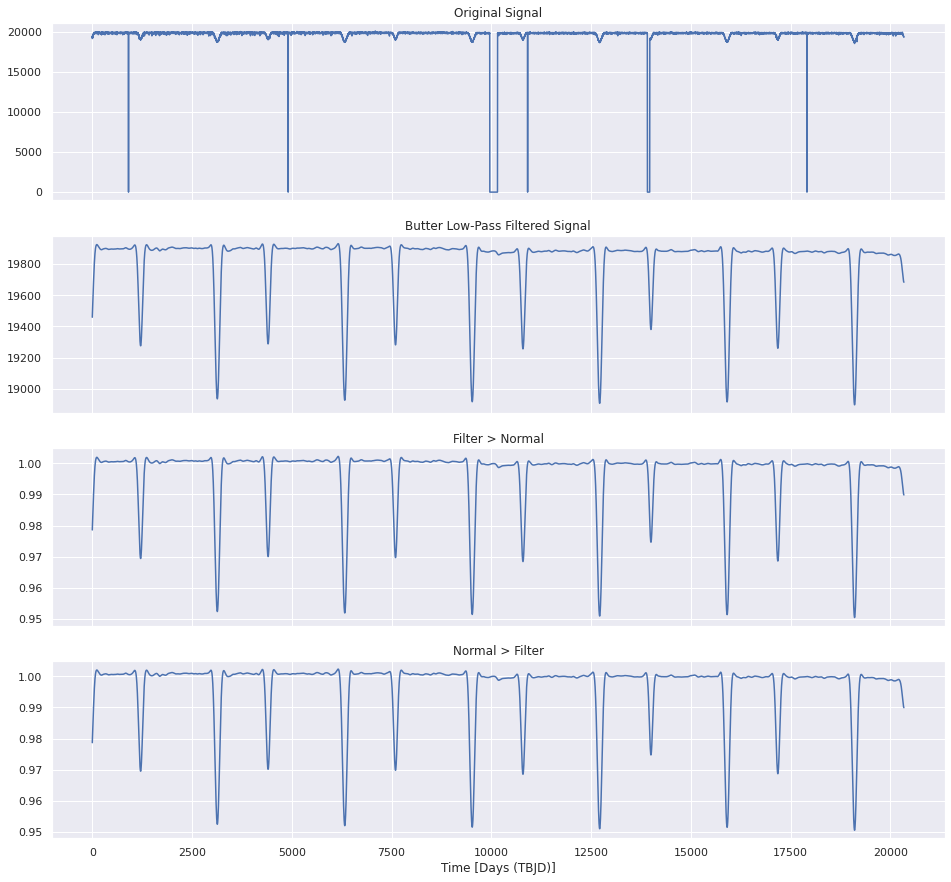

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

plt.rcParams["figure.figsize"] = (16,15)

ax1.plot(y)
ax1.set_title('Original Signal')

ax2.plot(Fy)
ax2.set_title('Butter Low-Pass Filtered Signal')

ax3.plot(FNy)
ax3.set_title('Filter > Normal')

ax4.plot(NFy)
ax4.set_title('Normal > Filter')
ax4.set_xlabel('Time [Days (TBJD)]')

#plt.tight_layout()
plt.show()

(0.995, 1.005)

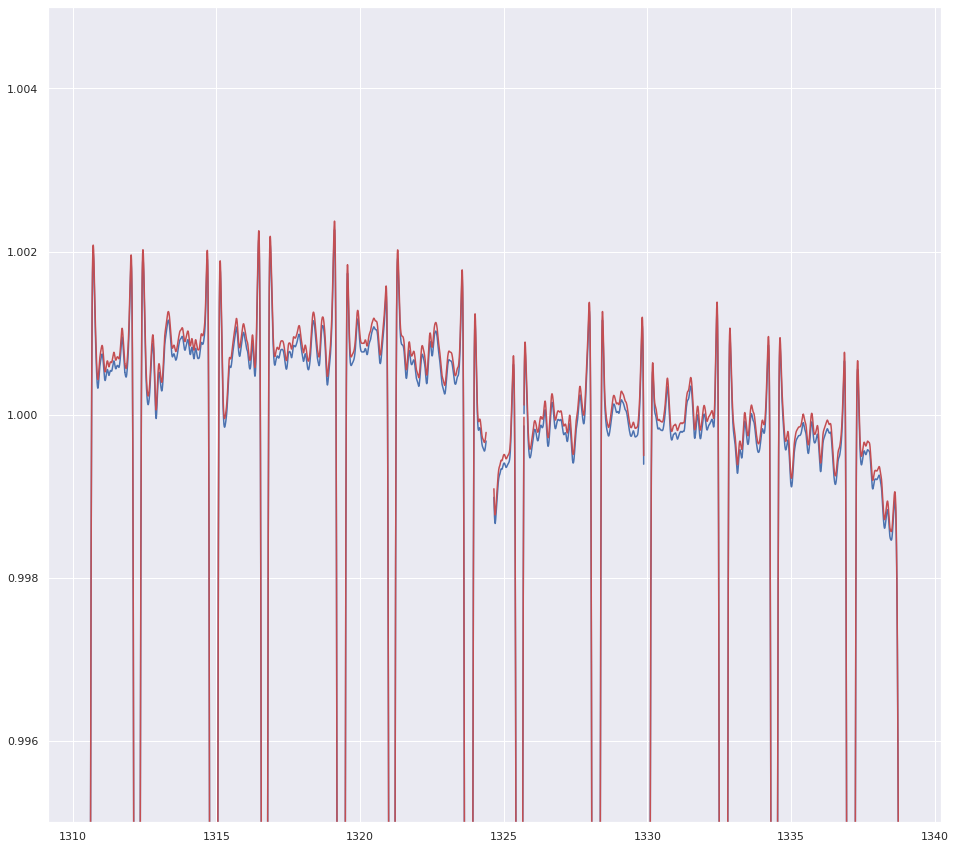

In [32]:
plt.plot(FNx, FNy, 'b-')
plt.plot(NFx, NFy, 'r-')
plt.ylim([0.995,1.005])

### Doesn't seem to make a HUGE difference whether you Filter first or Normalise

In [33]:
plt.rcParams["figure.figsize"] = default_rc_params

In [34]:
shortX, shortY = Every_Nth_Value(nX, nY, 10)

plt.plot(shortX,shortY)

NameError: name 'nX' is not defined

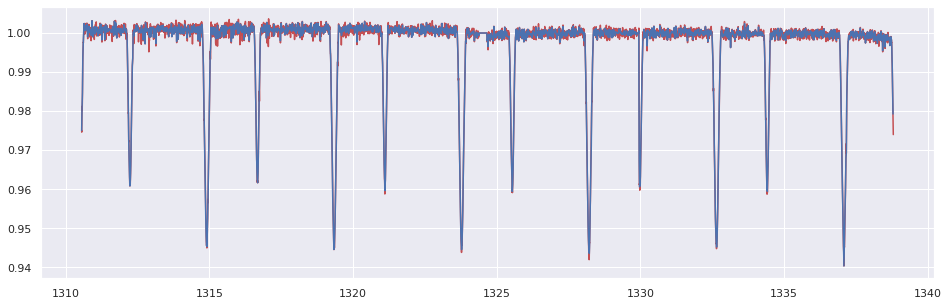

In [ ]:
plt.plot(nX,nY,'r-')
plt.plot(shortX, shortY, 'b-')

### I'd say that's a cracking success!
(In above graph, Low-Pass Filtered signal shown in red; subsampled signal shown in blue, overlayed)

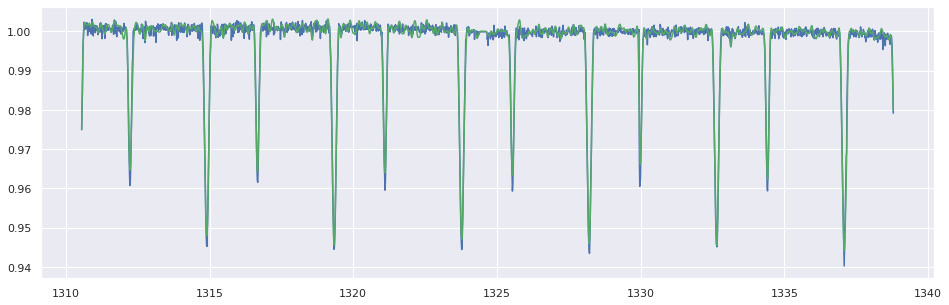

In [ ]:
zX, zY = Every_Nth_Value(x,y,10)
zzX, zzY = FilterMyData(zX, zY)

plt.plot(shortX, shortY, 'b-')
plt.plot(zzX, zzY, 'g-')

### It is better to apply the filter and *then* subsample, as opposed to the other way around!
(Note missing tips from some of the valleys!)  
(In above graph, Filtered > Shortened signal shown in blue; Shortened > Filtered signal shown in green, overlayed)

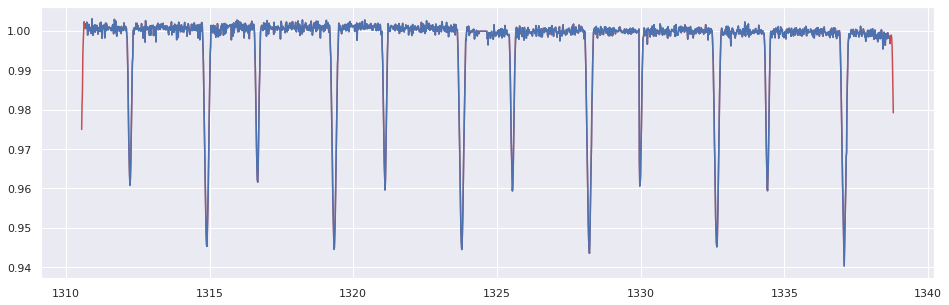

In [ ]:
plt.plot(shortX, shortY, 'r-')
plt.plot(shortX[10:-10], shortY[10:-10], 'b-')

### Maybe take a windowed approach? Ignore first and last (say) 10 digits?
(In above graph, subsampled signal shown in red; 'windowed' signal shown in blue, overlayed)  
(Note the very edges are ignored, and everything else is the same, as expected)  

# Now I have to put this in a pipeline!!!

In [78]:
fluxarrFULL = np.load("None_Or_One_Exoplanet.npy")
#fluxarrFULL = fluxarrFULL[1:-1]

In [80]:
len(fluxarrFULL[0])

20340

In [95]:
K = fluxarrFULL[:4]
K

array([[    0.    ,  5934.8354,  5876.6846, ...,  5871.7227,  5952.542 ,
            0.    ],
       [    0.    , 24177.342 , 24077.414 , ..., 23877.11  , 24092.688 ,
            0.    ],
       [    0.    ,  5452.441 ,  5439.1523, ...,  5417.7715,  5435.0806,
            0.    ],
       [    0.    ,  5994.8257,  6045.171 , ...,  5964.573 ,  6009.199 ,
            0.    ]], dtype=float32)

In [20]:
TMP = np.load("None_Or_One_Exoplanet.npy")[:, 1:-1]
#NEW = np.load("None_Or_One_Fluxes_TRIMMED.npy")
#NEW = np.zeros([len(TMP), len(TMP[0])-2]).astype('float32')

In [22]:
len(TMP)

9154

In [192]:
len(NEW[0])

20338

In [176]:
for i in range(len(NEW)):
    NEW[i] = TMP[i][1:-1]

In [189]:
TMP.dtype

dtype('float32')

In [190]:
NEW.dtype

dtype('float32')

In [199]:
L = 0

for i in range(len(NEW)):
    
    N = NEW[i]
    if len(N) != L:
        print(f"Change at index {i}! Old L: {L} -- New L: {len(N)}")
        L = len(N)
   

Change at index 0! Old L: 0 -- New L: 20338


In [179]:
np.save("None_Or_One_Fluxes_TRIMMED.npy", NEW)

In [180]:
del NEW

In [207]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [208]:
SHORT = NEW[:, ::10]

In [209]:
checkArr = np.load("one_or_none_isplanetlist.npy")

In [210]:
model = SVC(kernel='rbf', class_weight='balanced')
    
# Sort data into Test and Train
Xtrain, Xtest, ytrain, ytest = train_test_split(SHORT, checkArr, random_state=42)

param_grid = {'C': [1, 5],#, 50],
              'gamma': [0.0001, 0.0005]}#, 0.005]}

# Do gridsearch for svc params
print("> GPR-GRIDSEARCH")
grid = GridSearchCV(model, param_grid, n_jobs=6)

# Fit model
print("> GPR-FIT")
grid.fit(Xtrain, ytrain)

> GPR-GRIDSEARCH
> GPR-FIT


GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=6,
             param_grid={'C': [1, 5], 'gamma': [0.0001, 0.0005]})

In [97]:
C = np.load("None_Or_One_Exoplanet.npy")[:,1:-1]

In [98]:
len(C)

9154

In [99]:
len(C[0])

20338

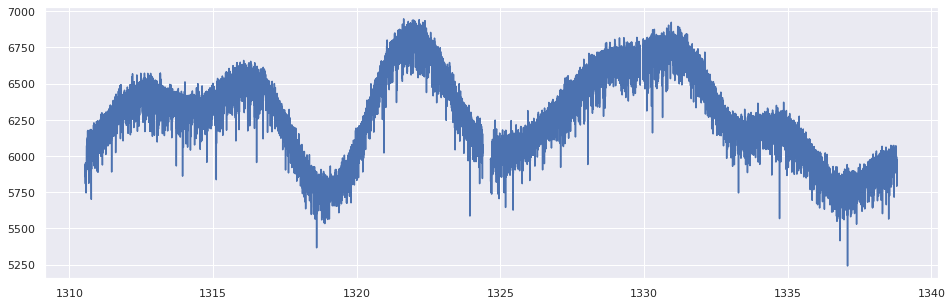

In [100]:
plt.plot(betterX,C[0])

# betterX defined way below

In [219]:
D = np.load("filteredfluxlistONEORNONE.npy")

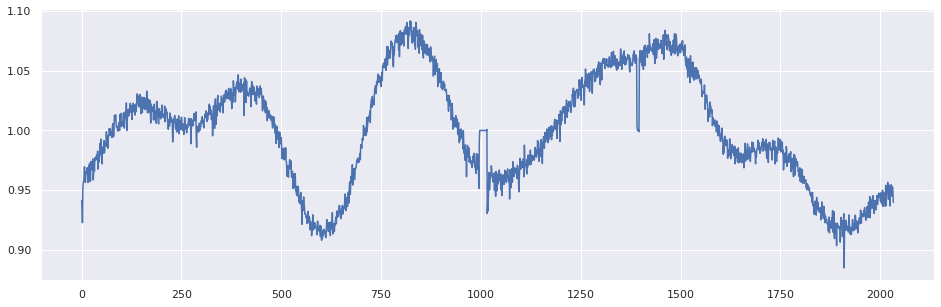

In [220]:
plt.plot(D[0])

In [16]:
fluxarrFULL = np.load("filteredfluxlistONEORNONE.npy")
fluxarrBASE = np.load("ZeroOrOneFoldedFluxesPREFOLD.npy")

In [3]:
J = np.zeros(len(fluxarrFULL))

In [5]:
len(J)

9154

In [6]:
for i in range(len(fluxarrFULL)):
    J[i] = min(fluxarrFULL[i])

In [7]:
min(J)

-63.57593536376953

In [10]:
J

array([ 0.88488966,  0.95983195,  0.97604716, ...,  0.98236358,
        0.89689755, -3.31640959])

In [12]:
mins = np.where(J <0)
mins

(array([ 257,  672, 3706, 4850, 4858, 5023, 7109, 9153]),)

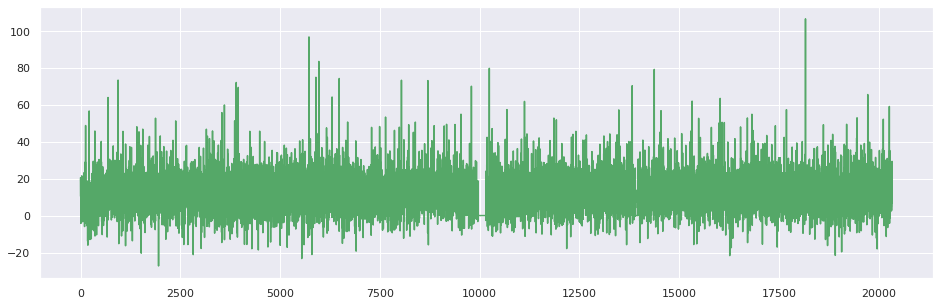

In [24]:
#plt.plot(fluxarrFULL[257], 'r')
plt.plot(TMP[257], 'g')
#plt.plot(fluxarrBASE[257], 'b')

In [18]:
len(fluxarrBASE)

9154

In [17]:
NoneOrOne = np.load("None_Or_One_Exoplanet.npy")

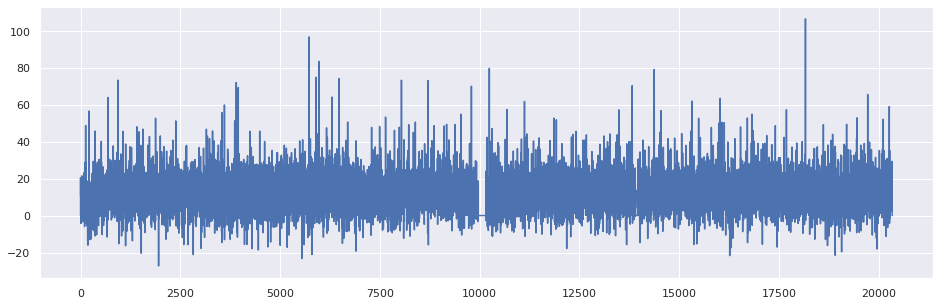

In [18]:
plt.plot(NoneOrOne[257])

In [35]:
minFlux = np.zeros(len(NoneOrOne))

for i in range(len(NoneOrOne)):
    minFlux[i] = min(NoneOrOne[i])

In [36]:
np.where(minFlux<0)

(array([ 257,  624,  672,  971, 1060, 1203, 2268, 2333, 2569, 2881, 2933,
        3706, 4850, 4858, 4906, 5023, 5074, 5501, 5529, 5543, 6029, 6059,
        6097, 6160, 7109, 7498, 7500, 7938, 8118, 9153]),)

In [23]:
minFlux[620:630]

array([     0.       ,      0.       ,      0.       ,      0.       ,
       -13707.4921875,      0.       ,      0.       ,      0.       ,
            0.       ,      0.       ])

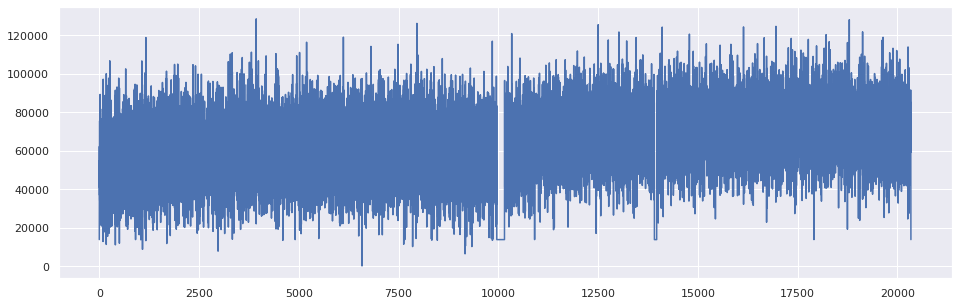

In [45]:
plt.plot(NoneOrOne[624])

In [31]:
K = NoneOrOne[:3].copy()
K

array([[    0.    ,  5934.8354,  5876.6846, ...,  5871.7227,  5952.542 ,
            0.    ],
       [    0.    , 24177.342 , 24077.414 , ..., 23877.11  , 24092.688 ,
            0.    ],
       [    0.    ,  5452.441 ,  5439.1523, ...,  5417.7715,  5435.0806,
            0.    ]], dtype=float32)

In [32]:
K[0][:] += 100
K

array([[  100.    ,  6034.8354,  5976.6846, ...,  5971.7227,  6052.542 ,
          100.    ],
       [    0.    , 24177.342 , 24077.414 , ..., 23877.11  , 24092.688 ,
            0.    ],
       [    0.    ,  5452.441 ,  5439.1523, ...,  5417.7715,  5435.0806,
            0.    ]], dtype=float32)

In [42]:
for n,i in enumerate(NoneOrOne):
    if min(i) < 0:
        print(f"Index {n} has min val of {min(i)}")
        i[:] = i[:]+np.abs(min(i))
        print(f"New min value is {min(i)}")

Index 257 has min val of -436.417236328125
New min value is 0.0
Index 624 has min val of -219319.875
New min value is 0.0
Index 672 has min val of -468.2894592285156
New min value is 0.0
Index 971 has min val of -2677.4326171875
New min value is 0.0
Index 1060 has min val of -149.8572540283203
New min value is 0.0
Index 1203 has min val of -3362.704833984375
New min value is 0.0
Index 2268 has min val of -4229.3701171875
New min value is 0.0
Index 2333 has min val of -2347.447021484375
New min value is 0.0
Index 2569 has min val of -882.1222534179688
New min value is 0.0
Index 2881 has min val of -220.2927703857422
New min value is 0.0
Index 2933 has min val of -88.31285858154297
New min value is 0.0
Index 3706 has min val of -51241.5859375
New min value is 0.0
Index 4850 has min val of -366.382568359375
New min value is 0.0
Index 4858 has min val of -2877.1884765625
New min value is 0.0
Index 4906 has min val of -846.6275634765625
New min value is 0.0
Index 5023 has min val of -1620.7

In [43]:
newMinFlux = np.zeros(len(NoneOrOne))

for i in range(len(NoneOrOne)):
    newMinFlux[i] = min(NoneOrOne[i])

In [51]:
np.save("None_Or_One_Exoplanet_POSITIVE.npy", NoneOrOne)

## Test BELOW: Seeing how to iterate the normalising, filtering, etc fns for ALL fluxes in the WHOLE set; not just a single flux observation

In [42]:
testData = np.load("None_Or_One_Exoplanet_POSITIVE.npy")[:, 1:-1]
betterX = np.load("X_TIME_LIST.npy")

Total Number of LCs to fix = 9154
TMP array has size (9154, 2034)
Done!
CPU times: user 7min, sys: 516 ms, total: 7min 1s
Wall time: 7min 1s


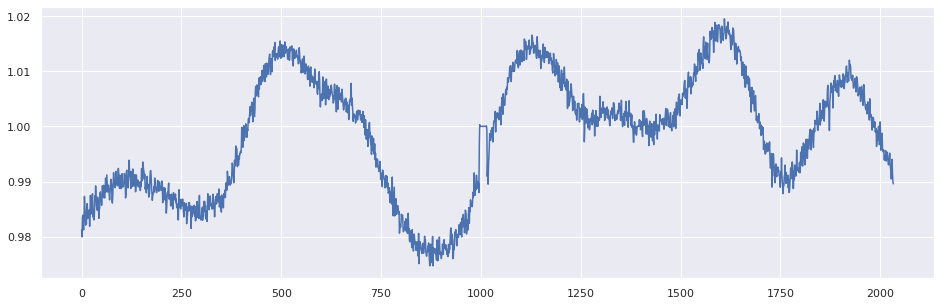

In [78]:
%%time
fixedData = FixAllData(testData)
plt.plot(fixedData[473])

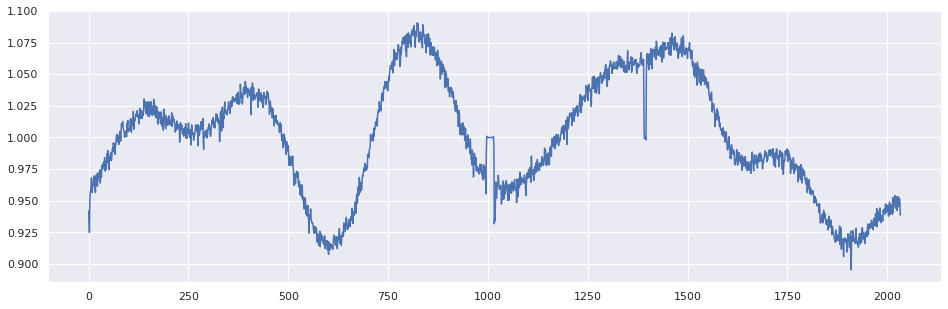

In [81]:
plt.plot(fixedData[0])

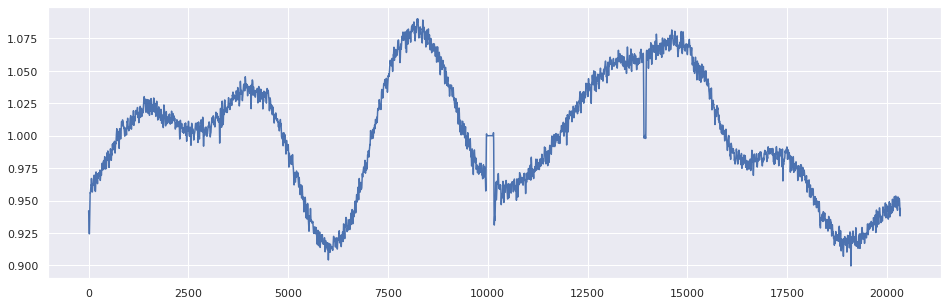

In [91]:
plt.plot(FilterMyData(testData[0],0.0004))

In [93]:
len(fixedData[0])

2034

In [94]:
np.save("None_Or_One_Exoplanet_FILT_NORM_SUBS.npy", fixedData)

## Test BELOW: Trying out SKLearn Preprocessing

In [121]:
from sklearn import preprocessing
Z = np.load("None_Or_One_Exoplanet_NORMALISED.npy")[:, 1:-1]

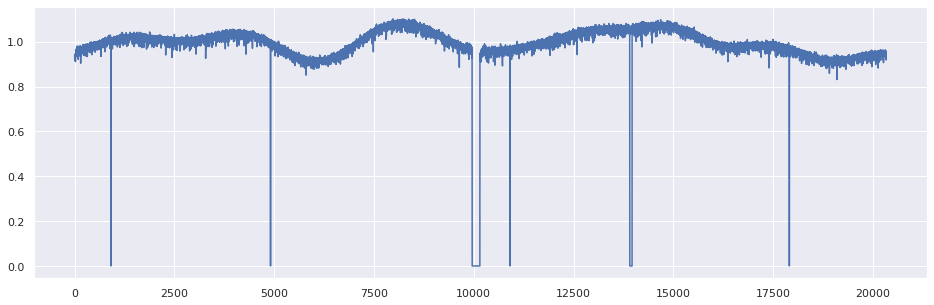

In [122]:
plt.plot(Z[0])

In [123]:
scaler = preprocessing.StandardScaler().fit(Z)

In [124]:
scaler

StandardScaler()

In [125]:
scaler.mean_

array([1.00287284, 0.9984202 , 0.99323757, ..., 0.99293483, 0.99239074,
       0.9980634 ])

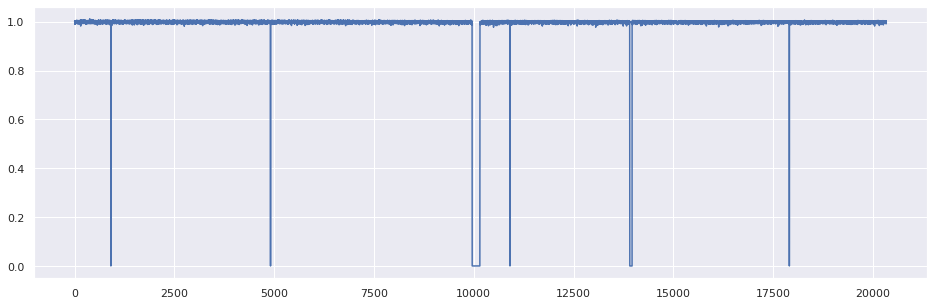

In [126]:
plt.plot(scaler.mean_)

In [127]:
scaler.scale_

array([0.28739304, 0.0991331 , 0.49197681, ..., 0.82182666, 0.86703764,
       0.34989584])

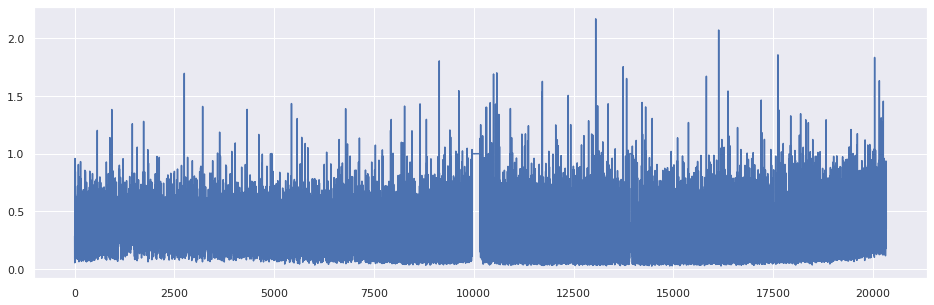

In [128]:
plt.plot(scaler.scale_)

In [129]:
X_scaled = scaler.transform(Z)
X_scaled

array([[-2.1386065e-01, -6.6812801e-01, -1.4596488e-01, ...,
        -8.4317103e-02, -7.0344374e-02, -1.5388560e-01],
       [-7.8970246e-02, -2.2488964e-01, -6.1150018e-02, ...,
        -4.4445436e-02, -2.8124666e-02, -6.0926810e-02],
       [ 4.6987347e-03,  3.3848863e-02,  1.2385108e-02, ...,
         9.0871966e-03,  6.2824953e-03,  8.4664952e-03],
       ...,
       [-1.6161529e-02, -4.1022889e-02, -5.2766019e-04, ...,
        -5.0125658e-03,  1.2322583e-02,  4.1014835e-04],
       [-1.7964438e-02, -4.6383706e-01, -1.2608589e-02, ...,
        -1.6699642e-02,  3.3373177e-02,  5.1604144e-02],
       [ 7.7817054e+00, -2.5480947e-01, -4.0991168e+00, ...,
         1.3626127e+00, -1.6285707e-01, -1.3605131e+00]], dtype=float32)

In [138]:
TESTNUM = 1024

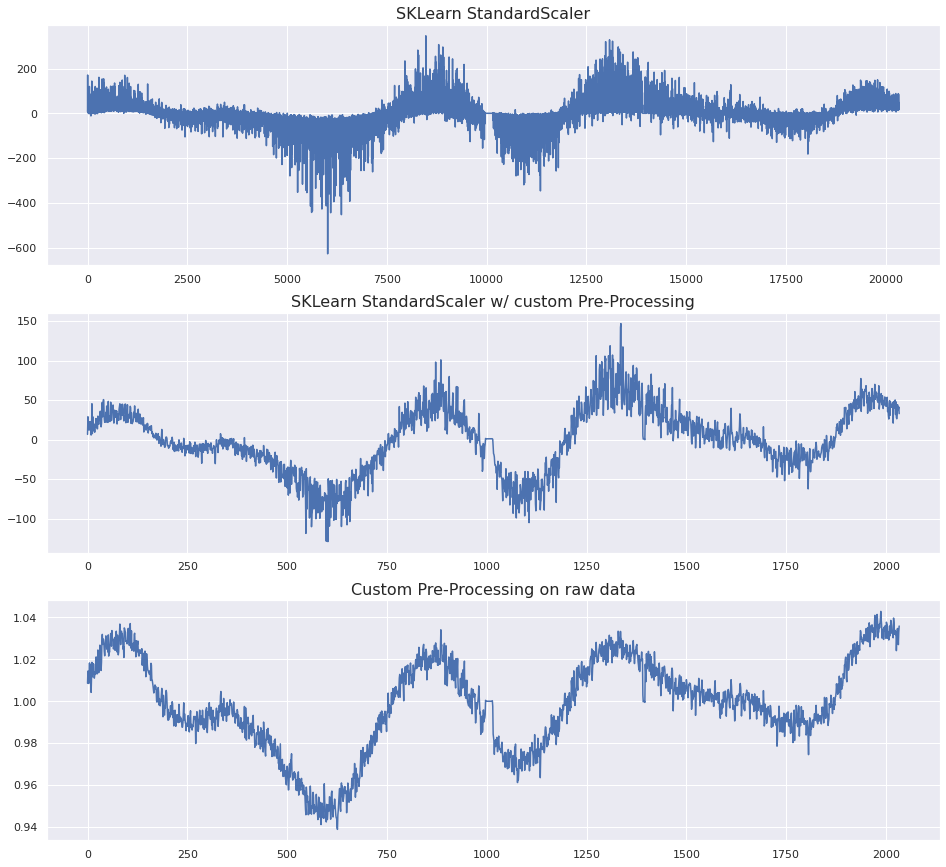

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False)

plt.rcParams["figure.figsize"] = (16,15)

ax1.plot(X_scaled[TESTNUM])
ax1.set_title('SKLearn StandardScaler', {'fontsize': 16})

ax2.plot(PreProcessData(X_scaled[TESTNUM]))
ax2.set_title('SKLearn StandardScaler w/ custom Pre-Processing', {'fontsize': 16})

ax3.plot(PreProcessData(Z[TESTNUM]))
ax3.set_title('Custom Pre-Processing on raw data', {'fontsize': 16})

#plt.tight_layout()
plt.show()

In [3]:
X = np.load("None_Or_One_Exoplanet_FILT_NORM_SUBS.npy")
y = np.load("one_or_none_isplanetlist.npy")

In [4]:
print("Splitting into Test and Train sets...")
X_nested = from_2d_array_to_nested(X)
X_train, X_test, y_train, y_test = train_test_split(X_nested, y)

Splitting into Test and Train sets...


In [6]:
np.save("./sktime_datasets/X_train.npy", X_train)
np.save("./sktime_datasets/X_test.npy", X_test)
np.save("./sktime_datasets/y_train.npy", y_train)
np.save("./sktime_datasets/y_test.npy", y_test)